In [1]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train).score(X_test, y_test)

# An estimator's parameter can be set using '__' syntax
pipe.set_params(svc__C=10).fit(X_train, y_train).score(X_test, y_test)


0.76

In [2]:
from typing import Any
from distributed import Client
from src.logging_utils.logger import logger
import os
from sklearn.pipeline import Pipeline
from src.pipeline.caching.tif import CacheTIFPipeline
from src.pipeline.model.feature.column.get_columns import get_columns
from src.pipeline.model.feature.error import FeaturePipelineError
from src.pipeline.model.feature.transformation.get_transformations import get_transformations
from joblib import hash
from rasterio.plot import show
from src.pipeline.model.feature.feature import FeaturePipeline
import numpy as np

Creating read tasks: 100%|██████████| 5635/5635 [00:00<00:00, 8224.80it/s] 


3.4102518558502197


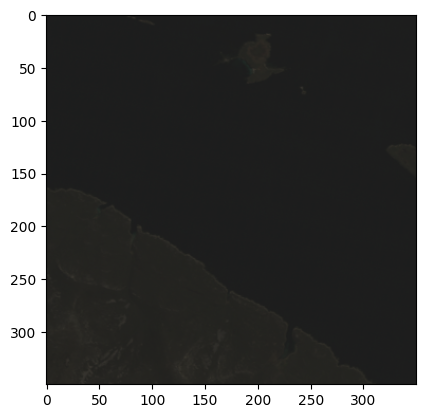

Creating read tasks: 100%|██████████| 5635/5635 [00:00<00:00, 7411.64it/s]


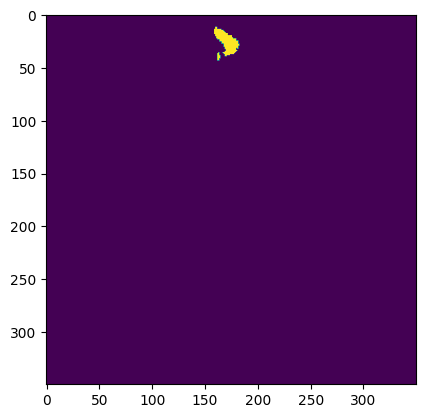

(5635, 7, 350, 350)


In [3]:
# Example test
raw_data_path = "data/raw/train_satellite"
target_path = "data/raw/train_kelp"
processed_path = "data/processed"
features_path = "data/features"
transform_steps = [{'type': 'divider', 'divider': 65500}]
columns: list[dict[str, Any]] = []

client = Client()
import time
orig_time = time.time()
# Create the feature pipeline
feature_pipeline = FeaturePipeline(
    raw_data_path, processed_path, transformation_steps=transform_steps, column_steps=columns)
label_pipeline = FeaturePipeline(
    target_path, processed_path, transformation_steps=transform_steps, column_steps=columns)

pipeline = feature_pipeline.get_pipeline()

# Parse the raw data
orig_time = time.time()
images = pipeline.fit_transform(None)
print(time.time() - orig_time)

# Display the first image
show(images[0].compute()[2:5])
label_pipeline = label_pipeline.get_pipeline()
labels = label_pipeline.fit_transform(None)
show(labels[0].compute())
print(images.shape)


In [4]:
import dask.array as da
from dask_ml.preprocessing import StandardScaler
from dask.distributed import Client

In [5]:
# now take 1 channel from the images
# and flatten the images so you have images.shape[1] x flattened len images

channel = 0
flattened_images = da.stack([da.ravel(image[channel])
                             for image in images])
# reshape the flattened images back to the original shape
print(flattened_images.shape)

(5635, 122500)


In [6]:
# apply the standard scaler to the flattened images
scaler = StandardScaler()
scaled_images = scaler.fit_transform(flattened_images.T)
print(scaled_images.shape)

TypeError: Chunking is only allowed on the first axis. Use 'array.rechunk({1: array.shape[1]})' to rechunk to a single block along the second axis.

In [ ]:
reconstructed_images = da.reshape(scaled_images,[5635,350,350])
print(reconstructed_images.shape)

(5635, 350, 350)


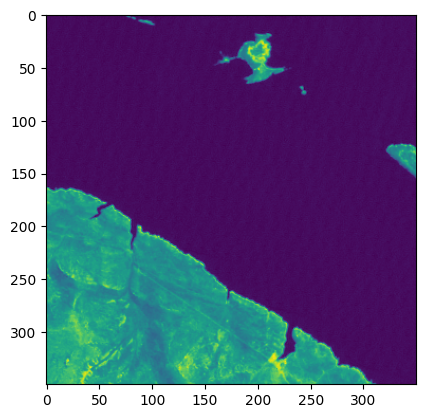

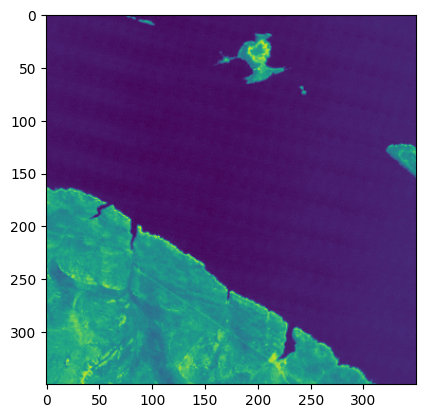

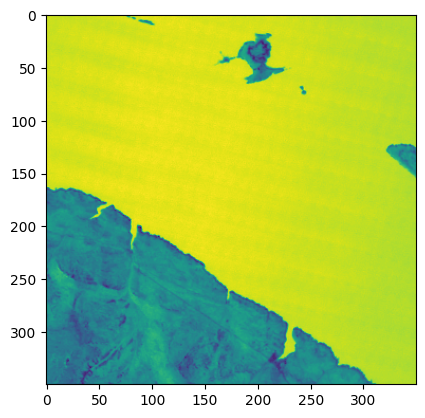

<Axes: >

In [ ]:
# show the original and reconstructed images

show(images[0].compute()[channel])
show(reconstructed_images[0].compute())
# also  show the difference between the original and reconstructed images
show(images[0].compute()[channel] - reconstructed_images[0].compute())

In [ ]:
# now compare the standard scaler to torch layernorm
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a torch tensor from the flattened images
torch_image = torch.tensor(flattened_images[0].compute())
torch_image = torch_image.reshape(350,350)
print(torch_image.shape)

# create a layer norm layer
layer_norm = nn.LayerNorm()
layer_norm_images = layer_norm(torch_image)
print(layer_norm_images.shape)
